In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# spark
import findspark
findspark.init('/usr/local/Cellar/apache-spark/2.4.5/libexec')
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import monotonically_increasing_id
import pyspark.sql.functions as F
from pyspark.sql.functions import concat, col, lit, when, max

# social network 
import networkx as nx

# emoji and regex
import functools
import operator
import re
import emoji
from collections import Counter

# Part 1: Text analytics 

## load dataset 

In [2]:
# initialise sparkContext
spark = SparkSession.builder \
        .master('local') \
        .appName('Venmo') \
        .config('spark.executor.memory', '10gb') \
        .config("spark.cores.max", "6") \
        .getOrCreate()

# read parquet file
df_venmo = spark.read.parquet('VenmoSample.snappy.parquet')

In [7]:
# count total number of records
df_venmo.count()

7113137

In [4]:
df_venmo.printSchema()

root
 |-- user1: integer (nullable = true)
 |-- user2: integer (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- description: string (nullable = true)
 |-- is_business: boolean (nullable = true)
 |-- story_id: string (nullable = true)



In [3]:
# add index column and create temporary view
df_venmo = df_venmo.withColumn("index", monotonically_increasing_id())
df_venmo.createOrReplaceTempView("Venmo")
df_venmo.show(5)

+-------+-------+----------------+-------------------+------------+-----------+--------------------+-----+
|  user1|  user2|transaction_type|           datetime| description|is_business|            story_id|index|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+-----+
|1218774|1528945|         payment|2015-11-27 02:48:19|        Uber|      false|5657c473cd03c9af2...|    0|
|5109483|4782303|         payment|2015-06-17 04:37:04|      Costco|      false|5580f9702b64f70ab...|    1|
|4322148|3392963|         payment|2015-06-19 00:05:31|Sweaty balls|      false|55835ccb1a624b14a...|    2|
| 469894|1333620|          charge|2016-06-03 16:34:13|          🎥|      false|5751b185cd03c9af2...|    3|
|2960727|3442373|         payment|2016-05-29 16:23:42|           ⚡|      false|574b178ecd03c9af2...|    4|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+-----+
only showing top 5 rows



## Use the text dictionary and the emoji dictionary to classify Venmo’s transactions in your sample dataset. 

In [4]:
# load word and emoji dictionaries (key words and emojis are classified to 9 major topics)
word_dictionary = pd.read_excel("word dictionary.xlsx")
emoji_dictionary = pd.read_excel("emoji dictionary.xlsx")
emoji_dictionary.head(2)

,People,Food,Event,Activity,Travel,Transportation,Utility,Cash,Illegal/Sarcasm
0,❤️,🍕,👰,🍻,🌴,⛽,🏡,💸,🖕🏿
1,👯,🍵,🎤,🏀,✈️,🅿,💡,💰,☠


In [5]:
# drop n/a values and create a list for each category
people1 = word_dictionary.People.dropna(how='all').values.tolist()
food1 = word_dictionary.Food.dropna(how='all').values.tolist()
event1 = word_dictionary.Event.dropna(how='all').values.tolist()
activity1 = word_dictionary.Activity.dropna(how='all').values.tolist()
travel1 = word_dictionary.Travel.dropna(how='all').values.tolist()
trasportation1 = word_dictionary.Transportation.dropna(how='all').values.tolist()
utility1 = word_dictionary.Utility.dropna(how='all').values.tolist()
cash1 = word_dictionary.Cash.dropna(how='all').values.tolist()
illegal_sarcasm1 = word_dictionary['Illegal/Sarcasm'].dropna(how='all').values.tolist()

people2 = emoji_dictionary.People.dropna(how='all').values.tolist()
food2 = emoji_dictionary.Food.dropna(how='all').values.tolist()
event2 = emoji_dictionary.Event.dropna(how='all').values.tolist()
activity2 = emoji_dictionary.Activity.dropna(how='all').values.tolist()
travel2 = emoji_dictionary.Travel.dropna(how='all').values.tolist()
trasportation2 = emoji_dictionary.Transportation.dropna(how='all').values.tolist()
utility2 = emoji_dictionary.Utility.dropna(how='all').values.tolist()
cash2 = emoji_dictionary.Cash.dropna(how='all').values.tolist()
illegal_sarcasm2 = emoji_dictionary['Illegal/Sarcasm'].dropna(how='all').values.tolist()

In [6]:
# slice dataframe having only emojis
emoji_tbl = spark.sql("select index, description \
                       from Venmo \
                       where HEX(description) REGEXP '^[E2|F0]{2}' \
                               and description NOT REGEXP '[g-zG-Z\\?\\!\\\\\.]'")

emoji_tbl.registerTempTable("emoji_tbl")

# slice dataframe having texts or mixed texts and emojis
short_venmo = spark.sql("select index, lower(description) as description from Venmo")
text_tbl = short_venmo.exceptAll(emoji_tbl).sort("index")

text_tbl.registerTempTable("text_tbl")

In [7]:
# text classification
text_class = text_tbl.select("*", 
            when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in people1])), 'people')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in food1])), 'food') \
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in event1])), 'event')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in activity1])), 'activity')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in travel1])), 'travel')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in trasportation1])), 'trasportation')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in utility1])), 'utility')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in cash1])), 'cash')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in illegal_sarcasm1])), 'illegal_sarcasm')\
                 .otherwise('no_class').alias('class'))

text_class.registerTempTable("text_class")

# count the number of records that has no class 
x = spark.sql("select * from text_class where class='no_class'")
print("The number of no_class records is", x.count())
text_class.show()

The number of no_class records is 0
+-----+--------------------+-------------+
|index|         description|        class|
+-----+--------------------+-------------+
|    0|                uber|trasportation|
|    1|              costco|         food|
|    2|        sweaty balls|         food|
|    5|          chipotlaid|         food|
|    6|     kitchen counter|      utility|
|    7|                food|         food|
|    8|               zaxby|         food|
|    9|           fan sucks|     activity|
|   11|         thanks babe|       people|
|   14|hey man  it's bee...|       people|
|   15|         getaway car|trasportation|
|   16|     🔮 gypsy things|     activity|
|   18|           furniture|      utility|
|   19|bed bath mostly b...|       people|
|   20|                 fun|     activity|
|   21|    world cup stacks|       travel|
|   22|you're lucky we d...|       people|
|   23|      cable part 2..|     activity|
|   24|               benny|         cash|
|   25|            

In [8]:
# emoji classification
emoji_class = emoji_tbl.select("*", 
    when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in people2])), 'people')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in food2])), 'food') \
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in event2])), 'event')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in activity2])), 'activity')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in travel2])), 'travel')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in trasportation2])), 'trasportation')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in utility2])), 'utility')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in cash2])), 'cash')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in illegal_sarcasm2])), 'illegal_sarcasm')\
                 .otherwise('no_class').alias('class'))

emoji_class.registerTempTable("emoji_class")

# count the number of records that has no class 
y = spark.sql("select * from emoji_class where class='no_class'")
print("The number of no_class records is", y.count())
emoji_class.show()

The number of no_class records is 491637
+-----+----------------+---------------+
|index|     description|          class|
+-----+----------------+---------------+
|    3|              🎥|       activity|
|    4|               ⚡|       no_class|
|   10|              👠|       activity|
|   12|              🍺|           food|
|   13|               ⛽|  trasportation|
|   17|              🔴|  trasportation|
|   48|            ✌❤🏈|       activity|
|   54|            👰👰|          event|
|   57|          🍕🍕🍕|           food|
|   60|              🍕|           food|
|   62|              🎉|       activity|
|   65|          🍴🍴🍴|           food|
|   66|      ☕️🍴🍰🍳🎂|           food|
|   68|              🏡|        utility|
|   71|              💣|illegal_sarcasm|
|   77|              🌮|           food|
|   82|              🍵|           food|
|   86|              ⚡️|       no_class|
|   91|❤️❤️❤️❤️👯👯👯😻|         people|
|   94|               ☕|           food|
+-----+----------------+---------------+
on

In [9]:
# union text and emoji dataset
df_class = spark.sql("select * from text_class union select * from emoji_class order by index")
df_class.registerTempTable("df_class")
df_class.show()

+-----+--------------------+-------------+
|index|         description|        class|
+-----+--------------------+-------------+
|    0|                uber|trasportation|
|    1|              costco|         food|
|    2|        sweaty balls|         food|
|    3|                  🎥|     activity|
|    4|                   ⚡|     no_class|
|    5|          chipotlaid|         food|
|    6|     kitchen counter|      utility|
|    7|                food|         food|
|    8|               zaxby|         food|
|    9|           fan sucks|     activity|
|   10|                  👠|     activity|
|   11|         thanks babe|       people|
|   12|                  🍺|         food|
|   13|                   ⛽|trasportation|
|   14|hey man  it's bee...|       people|
|   15|         getaway car|trasportation|
|   16|     🔮 gypsy things|     activity|
|   17|                  🔴|trasportation|
|   18|           furniture|      utility|
|   19|bed bath mostly b...|       people|
+-----+---------

## What is the percent of emoji only transactions? Which are the top 5 most popular emoji? Which are the top three most popular emoji categories? 

**What is the percent of emoji only transactions?**

In [10]:
emoji_per = emoji_tbl.count()/df_venmo.count()
emoji_per

0.2621712473694799

**Which are the top 5 most popular emoji?**

In [11]:
# create emoji list
emoji_list = emoji_tbl.select("description").rdd.flatMap(lambda x: x).collect()
len(emoji_list)

1864860

In [12]:
# split emoji_list[0] as the starter
em_split_emoji = emoji.get_emoji_regexp().split(emoji_list[0])
em_split_whitespace = [substr.split() for substr in em_split_emoji]
split_emoji_list = functools.reduce(operator.concat, em_split_whitespace)

# extend list starting from emoji_list[0]
for i in range(len(emoji_list)-1):
    next_emoji = "".join(emoji_list[i+1].split()) 
    split_emoji_list.extend(next_emoji)

# filter out empty elements
split_emoji_list = list(filter(lambda x: x != '️', split_emoji_list))

# count emoji frequency and find top 5 popular emojis
emoji_freq = Counter(split_emoji_list)
emoji_freq.most_common(5)

[('🍕', 186979), ('🍻', 114195), ('💸', 91973), ('🍷', 88363), ('🍺', 70590)]

**Which are the top three most popular emoji categories?**

In [13]:
# group by class and aggregate emojis in each class
agg_class = emoji_class.groupby("class")\
           .agg(F.concat_ws("", F.collect_list(emoji_class.description)).alias('agg_emojis'))
agg_class.registerTempTable("agg_class")

# transfer to pandas dataframe
pandas_venmo = agg_class.select("*").toPandas()
pandas_venmo.head()

,class,agg_emojis
0,travel,🌴🌴🌴🐟🐠🐟🐠🐟🌴🌴🌴✈️🚌🚡🚡🚡🚡🚡🚡🚡🚡🚡🚡💒✈️✈️🇭🇷🇭🇷🇭🇷🌴🌴✈️🌴✈️🏣🇮🇪🔵...
1,no_class,⚡⚡️🇺🇸🎯👃🏻👃🏽👃🏿🐍🔥🔥🔥💦💦💦👣⚡️🕶🐭👅⛄️🌏✒️✒️✒️💆🏼👻👻👻💚☘🤖✨👕👧🚛...
2,utility,🏡💡🔌📺📺📺⚡🔌💡💸🏡⚡🔌💡💸🚒💦🔥🖥🖥🏡⚡🔌💡💸🛁👩‍👩‍👧🏡🏠📺💸🔑🏠💸🏡💸📺📺💻💦🔌🔥...
3,food,🍺🍕🍕🍕🍕🍴🍴🍴☕️🍴🍰🍳🎂🌮🍵☕🍷🍷🍷🍰🍰🍰🍰🍰🍪🍪🍪🍺🍺🍇🍌🍓🍹🚗➡️🍟🍺🍕🍕🍕🍕🍕🍕🍷...
4,cash,💰🇮🇱🤑💰⛏⚱🤑💰🤑🤑🤑🤑🤑💵💸💰💵💵🌟💸💦💸💰🤑💸💰💰💦💸💰🏧💰 🔙💰💵💸💵💵💸💵🔙💸💦💸...


In [14]:
# If remove the no_class, "Food", "Activity", and "People" are the top 3 emoji categories
x = pandas_venmo.groupby("class")["agg_emojis"]\
            .apply(lambda x: x.str.len()).reset_index().sort_values("agg_emojis", ascending=False)

class_cnt = pd.concat([pandas_venmo["class"],x], axis=1).sort_values("agg_emojis", ascending=False)
class_cnt.head(10)

,class,index,agg_emojis
3,food,3,1667773
1,no_class,1,1056768
8,activity,8,591270
5,people,5,457549
2,utility,2,365662
7,trasportation,7,187082
9,event,9,110588
0,travel,0,107989
6,illegal_sarcasm,6,86135
4,cash,4,84001


## For each user, create a variable to indicate their spending behavior profile.  

In [10]:
# join Venmo original dataset with the dataset from question 1 that has description classification
df_full = spark.sql("select t1.index, user1, t1.description, class, datetime \
                    from df_class t1 join Venmo t2 using (index) order by index")
df_full.registerTempTable("df_full")
df_full.show(4)

+-----+-------+------------+-------------+-------------------+
|index|  user1| description|        class|           datetime|
+-----+-------+------------+-------------+-------------------+
|    0|1218774|        uber|trasportation|2015-11-27 02:48:19|
|    1|5109483|      costco|         food|2015-06-17 04:37:04|
|    2|4322148|sweaty balls|         food|2015-06-19 00:05:31|
|    3| 469894|          🎥|     activity|2016-06-03 16:34:13|
+-----+-------+------------+-------------+-------------------+
only showing top 4 rows



In [11]:
# For each user, calculate the number of his/her transactions per class and how many percents of total spendings 
df_profile = spark.sql("select user1, class, count(*) as transactions_per_class, \
                    concat(round(count(*)/sum(count(*)) over (partition by user1) *100, 2),'%') as ratio \
               from df_full \
               group by user1, class \
               order by user1")
df_profile.show()

+-----+--------+----------------------+------+
|user1|   class|transactions_per_class| ratio|
+-----+--------+----------------------+------+
|    2|  people|                     1|100.0%|
|    3|  people|                     3| 50.0%|
|    3|  travel|                     1|16.67%|
|    3|    cash|                     1|16.67%|
|    3|    food|                     1|16.67%|
|    4|    food|                     1|16.67%|
|    4|activity|                     1|16.67%|
|    4|    cash|                     1|16.67%|
|    4|no_class|                     1|16.67%|
|    4|  people|                     2|33.33%|
|   10|activity|                     1| 10.0%|
|   10|    food|                     5| 50.0%|
|   10|    cash|                     1| 10.0%|
|   10|  people|                     3| 30.0%|
|   11|  people|                     9| 36.0%|
|   11|    cash|                     7| 28.0%|
|   11|    food|                     4| 16.0%|
|   11|  travel|                     1|  4.0%|
|   11|activi

In [12]:
# create a list with unique classes 
categories = sorted(df_profile.select("class").distinct().rdd.map(lambda row: row[0]).collect())

cols = [when(col("class") == category, col("ratio")).otherwise(None).alias(category) 
    for category in categories]

maxs = [max(col(category)).alias(category) for category in categories]

# create static spending profile for each user
static_profile = (df_profile.select(col("user1"), *cols).groupBy("user1").agg(*maxs).na.fill(0))

static_profile.registerTempTable("static_profile")
static_profile.show()

+-----+--------+------+-----+------+---------------+--------+------+-------------+------+-------+
|user1|activity|  cash|event|  food|illegal_sarcasm|no_class|people|trasportation|travel|utility|
+-----+--------+------+-----+------+---------------+--------+------+-------------+------+-------+
|    2|    null|  null| null|  null|           null|    null|100.0%|         null|  null|   null|
|    3|    null|16.67%| null|16.67%|           null|    null| 50.0%|         null|16.67%|   null|
|    4|  16.67%|16.67%| null|16.67%|           null|  16.67%|33.33%|         null|  null|   null|
|   10|   10.0%| 10.0%| null| 50.0%|           null|    null| 30.0%|         null|  null|   null|
|   11|    8.0%| 28.0%| null| 16.0%|           null|    null| 36.0%|         null|  4.0%|   8.0%|
|   12|  11.11%|44.44%| null|11.11%|           null|    null|33.33%|         null|  null|   null|
|   13|  15.79%|15.79%| null|15.79%|           null|    null|47.37%|         null|  null|  5.26%|
|   16|   10.0%|  nu

In [17]:
# df_profile = df_profile.withColumn("dict", concat(col("ratio"), lit(" "), col("class")))
# df_profile = df_profile.groupby("user1").agg(F.concat_ws(", ", 
#                                     F.collect_list(df_profile.dict)).alias("static_profile"))
# df_profile.registerTempTable("df_profile")
# df_profile.show(10, truncate = False)

+-----+---------------------------------------------------------------------------------------------------------+
|user1|static_profile                                                                                           |
+-----+---------------------------------------------------------------------------------------------------------+
|2    |100.0%people                                                                                             |
|3    |16.67%no_class, 50.0%people, 16.67%travel, 16.67%food                                                    |
|4    |16.67%illegal_sarcasm, 16.67%food, 33.33%people, 16.67%activity, 16.67%no_class                          |
|10   |10.0%no_class, 30.0%people, 10.0%activity, 50.0%food                                                     |
|11   |4.0%activity, 36.0%people, 4.0%illegal_sarcasm, 20.0%no_class, 20.0%food, 8.0%travel, 8.0%utility        |
|12   |33.33%people, 11.11%activity, 33.33%no_class, 11.11%food, 11.11%illegal_sarcasm  

## For each user, create a dynamic spending profile (12 months)

In [12]:
# navigate the first transaction date and only keep first 12 months transactions for each user 
days_tbl = spark.sql("select user1, datetime, class, datediff(datetime, \
                first_value(datetime) over (partition by user1 order by datetime)) as days \
                from df_full \
                group by user1, datetime, class\
                order by user1")
days_tbl.show()

+-----+-------------------+--------+----+
|user1|           datetime|   class|days|
+-----+-------------------+--------+----+
|    2|2012-11-22 22:03:42|  people|   0|
|    3|2016-10-07 01:50:23|    cash|  15|
|    3|2016-10-08 18:56:24|  people|  16|
|    3|2016-10-08 20:36:13|    food|  16|
|    3|2016-09-22 08:30:09|  people|   0|
|    3|2016-10-07 16:37:56|  people|  15|
|    3|2016-10-06 03:49:45|  travel|  14|
|    4|2016-04-16 20:35:09|activity|1231|
|    4|2016-03-03 04:45:57|no_class|1187|
|    4|2015-06-17 02:23:30|    cash| 927|
|    4|2014-02-03 22:51:33|  people| 428|
|    4|2012-12-14 21:51:12|  people|  12|
|    4|2012-12-02 19:35:53|    food|   0|
|   10|2016-01-30 06:42:13|    food|1161|
|   10|2012-11-25 01:20:39|  people|   0|
|   10|2013-01-14 00:18:43|    food|  50|
|   10|2013-03-03 04:47:10|    food|  98|
|   10|2015-01-21 15:29:21|  people| 787|
|   10|2013-03-10 21:38:51|  people| 105|
|   10|2012-12-31 04:44:12|activity|  36|
+-----+-------------------+-------

In [13]:
# add lifetime indiactor (0-12 where 0 represents the 1st transaction and 1 represents 1 month and so on)
days_lifeindicator_tbl = days_tbl.select("*", 
            when(days_tbl.days==0, 0)\
         .when((days_tbl.days>0) & (days_tbl.days<=30), 1) \
         .when((days_tbl.days>30) & (days_tbl.days<=60), 2) \
         .when((days_tbl.days>60) & (days_tbl.days<=90), 3)\
         .when((days_tbl.days>90) & (days_tbl.days<=120), 4)\
         .when((days_tbl.days>120) & (days_tbl.days<=150), 5)\
         .when((days_tbl.days>150) & (days_tbl.days<=180), 6)\
         .when((days_tbl.days>180) & (days_tbl.days<=210), 7)\
         .when((days_tbl.days>210) & (days_tbl.days<=240), 8)\
         .when((days_tbl.days>240) & (days_tbl.days<=270), 9)\
         .when((days_tbl.days>270) & (days_tbl.days<=300), 10)\
         .when((days_tbl.days>300) & (days_tbl.days<=330), 11)\
         .when((days_tbl.days>330) & (days_tbl.days<=360), 12)\
         .otherwise(-1).alias('lifetime_indicator'))

# filter out records where "datetime-startdate">=360 days (12 months after first transaction)
lifetime_tbl = days_lifeindicator_tbl.filter("lifetime_indicator != -1 ").sort("user1")

lifetime_tbl.show()

+-----+-------------------+--------+----+------------------+
|user1|           datetime|   class|days|lifetime_indicator|
+-----+-------------------+--------+----+------------------+
|    2|2012-11-22 22:03:42|  people|   0|                 0|
|    3|2016-10-07 16:37:56|  people|  15|                 1|
|    3|2016-10-08 20:36:13|    food|  16|                 1|
|    3|2016-09-22 08:30:09|  people|   0|                 0|
|    3|2016-10-06 03:49:45|  travel|  14|                 1|
|    3|2016-10-07 01:50:23|    cash|  15|                 1|
|    3|2016-10-08 18:56:24|  people|  16|                 1|
|    4|2012-12-02 19:35:53|    food|   0|                 0|
|    4|2012-12-14 21:51:12|  people|  12|                 1|
|   10|2013-03-10 21:38:51|  people| 105|                 4|
|   10|2012-11-25 01:20:39|  people|   0|                 0|
|   10|2013-03-03 04:47:10|    food|  98|                 4|
|   10|2013-01-14 00:18:43|    food|  50|                 2|
|   10|2013-04-05 02:48:

In [14]:
lifetime_tbl = lifetime_tbl\
        .withColumn("lifetime_category", 
                        concat(lit("time"), col("lifetime_indicator"), lit("_"), col("class")))\
        .withColumn("user_life", concat(col("user1"), lit("_"), col("lifetime_indicator")))

lifetime_tbl.registerTempTable("lifetime_tbl")

dynamic_tbl = spark.sql("select user1, lifetime_category, \
                 round(count(*)/sum(count(*)) over (partition by user_life), 2) as percentage \
               from lifetime_tbl \
               group by user1, user_life, lifetime_category \
               order by user1")

dynamic_tbl.registerTempTable("dynamic_tbl")

dynamic_tbl.show()

+-----+-----------------+----------+
|user1|lifetime_category|percentage|
+-----+-----------------+----------+
|    2|     time0_people|       1.0|
|    3|     time1_people|       0.4|
|    3|       time1_cash|       0.2|
|    3|     time1_travel|       0.2|
|    3|       time1_food|       0.2|
|    3|     time0_people|       1.0|
|    4|     time1_people|       1.0|
|    4|       time0_food|       1.0|
|   10|       time1_food|       1.0|
|   10|   time2_activity|       0.5|
|   10|     time4_people|       0.5|
|   10|       time4_food|       0.5|
|   10|     time0_people|       1.0|
|   10|       time5_cash|       1.0|
|   10|       time2_food|       0.5|
|   11|       time0_food|       1.0|
|   11|       time5_food|       0.5|
|   11|     time6_people|       1.0|
|   11|       time3_cash|       1.0|
|   11|       time4_food|       1.0|
+-----+-----------------+----------+
only showing top 20 rows



In [15]:
# create dynamic profile
#spread rows to columns: each row representing one user, each column representing lifetime and spending category

life_cates = sorted(dynamic_tbl.select("lifetime_category").distinct().rdd.map(lambda row: row[0]).collect())

cols1 = [when(col("lifetime_category") == life_cate, col("percentage")).otherwise(None).alias(life_cate) 
    for life_cate in life_cates]

maxs1 = [max(col(life_cate)).alias(life_cate) for life_cate in life_cates]

dynamic_profile = (dynamic_tbl.select(col("user1"), *cols1).groupBy("user1").agg(*maxs1).na.fill(0))

dynamic_profile.registerTempTable("dynamic_profile")

# show partial dataset (1-8 columns and 1-20 rows)
dynamic_profile.select(dynamic_profile.columns[:8]).show()

+-----+--------------+----------+-----------+----------+---------------------+--------------+------------+
|user1|time0_activity|time0_cash|time0_event|time0_food|time0_illegal_sarcasm|time0_no_class|time0_people|
+-----+--------------+----------+-----------+----------+---------------------+--------------+------------+
|    2|           0.0|       0.0|        0.0|       0.0|                  0.0|           0.0|         1.0|
|    3|           0.0|       0.0|        0.0|       0.0|                  0.0|           0.0|         1.0|
|    4|           0.0|       0.0|        0.0|       1.0|                  0.0|           0.0|         0.0|
|   10|           0.0|       0.0|        0.0|       0.0|                  0.0|           0.0|         1.0|
|   11|           0.0|       0.0|        0.0|       1.0|                  0.0|           0.0|         0.0|
|   12|           0.0|       0.0|        0.0|       0.0|                  0.0|           0.0|         1.0|
|   13|           0.0|       0.0|    

In [18]:
# calculate mean, standard deviation for each time period and each class
summary_stats = dynamic_profile.summary()
df_dynamic_summary = summary_stats.select("*").toPandas()
df_dynamic_summary = df_dynamic_summary.T.reset_index() # transpose and reset index
headers = df_dynamic_summary.iloc[0] # store new header values
df_dynamic_summary = df_dynamic_summary[2:] # remove user1 information and previous header
df_dynamic_summary.columns = headers
df_dynamic_summary = df_dynamic_summary.reset_index(drop=True)
df_dynamic_summary.head()

,summary,count,mean,stddev,min,25%,50%,75%,max
0,time0_activity,2158528,0.12843825051145957,0.33406685333468933,0.0,0.0,0.0,0.0,1.0
1,time0_cash,2158528,0.2513680156106382,0.43303739637783334,0.0,0.0,0.0,0.6,1.0
2,time0_event,2158528,0.013661930723159488,0.11592848163120395,0.0,0.0,0.0,0.0,1.0
3,time0_food,2158528,0.23720214887182375,0.4246861125589359,0.0,0.0,0.0,0.0,1.0
4,time0_illegal_sarcasm,2158528,0.004347671190737391,0.06568058689262556,0.0,0.0,0.0,0.0,1.0


In [23]:
# add time and category columns for plotting 
time = []
category = []

for i in range(len(df_dynamic_summary)):
    pos = df_dynamic_summary.summary[i].index("_")
    c = df_dynamic_summary.summary[i][pos+1:]  # get category
    t = df_dynamic_summary.summary[i][4:pos]   # get lifetime
    time.append(t)
    category.append(c)

df_dynamic_summary["time"] = time
df_dynamic_summary["category"] = category

# convert data type from string to numeric 
df_dynamic_summary["time"] = df_dynamic_summary["time"].apply(pd.to_numeric, errors='coerce')
df_dynamic_summary["mean"] = df_dynamic_summary["mean"].apply(pd.to_numeric, errors='coerce')
df_dynamic_summary["stddev"] = df_dynamic_summary["stddev"].apply(pd.to_numeric, errors='coerce')
df_dynamic_summary["2std"] = 2*df_dynamic_summary["stddev"]

df_dynamic_summary.head()

,summary,count,mean,stddev,min,25%,50%,75%,max,time,category,2std
0,time0_activity,2158528,0.128438,0.334067,0.0,0.0,0.0,0.0,1.0,0,activity,0.668134
1,time0_cash,2158528,0.251368,0.433037,0.0,0.0,0.0,0.6,1.0,0,cash,0.866075
2,time0_event,2158528,0.013662,0.115928,0.0,0.0,0.0,0.0,1.0,0,event,0.231857
3,time0_food,2158528,0.237202,0.424686,0.0,0.0,0.0,0.0,1.0,0,food,0.849372
4,time0_illegal_sarcasm,2158528,0.004348,0.065681,0.0,0.0,0.0,0.0,1.0,0,illegal_sarcasm,0.131361


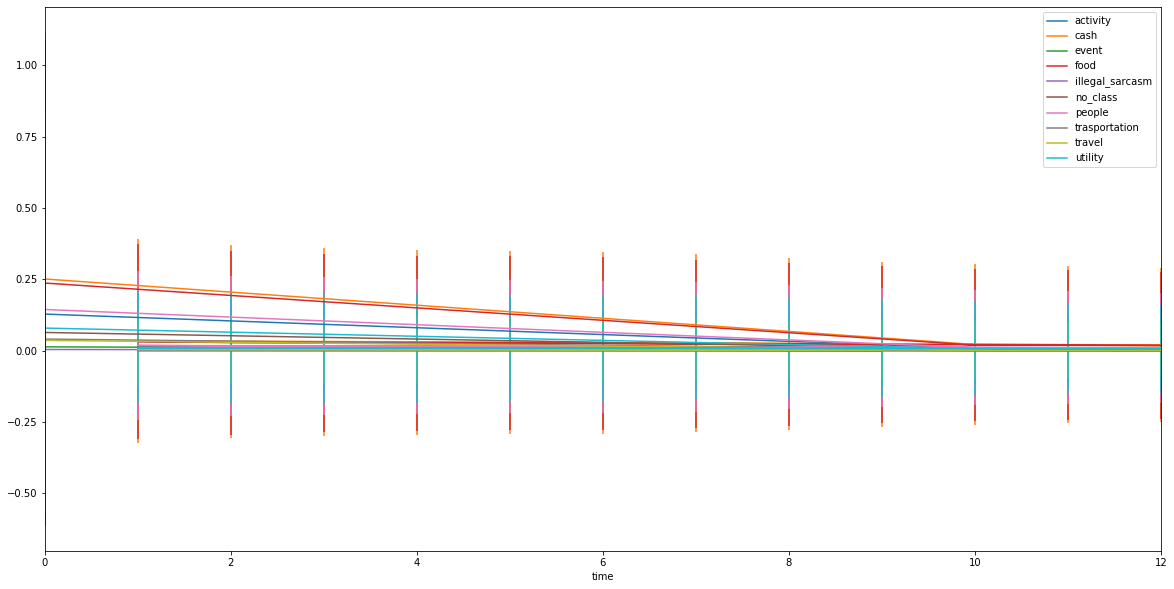

In [24]:
# after lifetime 10, the means for all categories' spendings are stable and close to zero. 
fig, ax = plt.subplots(figsize=(20, 10))

for key, group in df_dynamic_summary.groupby('category'):
    group.plot('time', 'mean', yerr='2std', label=key, ax=ax) 

plt.show()

# Part 2: Social network analytics 

## Find a user’s friends and friends of friends 

In [4]:
# PageRank, Connected Components, Triangle Counting
import networkx as nx

In [5]:
edges = spark.sql("select user1, user2 from Venmo")
df_edges = edges.select("*").toPandas()
df_edges.head(3)

,user1,user2
0,1218774,1528945
1,5109483,4782303
2,4322148,3392963


In [16]:
# initiate empty directed graph
DG = nx.DiGraph()

pairs = list(zip(df_edges.user1, df_edges.user2))
DG.add_edges_from(pairs)
#list(G.nodes)
#list(G.edges)
# nx.draw_networkx(G)

print(DG.number_of_nodes())
print(DG.number_of_edges())
print(nx.info(DG))

3018657
5534634


In [19]:
nx.degree(DG, 1218774)

5

## Use the dynamic analysis from before, and calculate the social network metrics across a user’s lifetime in Venmo 

**i) Number of friends and number of friends of friends**

In [ ]:
nx.degree(G, user1)

**ii) Clustering coefficient of a user's network**

In [ ]:
nx.clustering(Graph, Node)

**iii) Calculate the page rank of each user**

# Part 3: Predictive analytics with MLlib 

## Create dependent variable Y - the total number of transactions during her/his twelve months in Venmo

In [16]:
# calculate total number of transactions for each user on Venmo
df_y = spark.sql("select user1, count(*) as y from lifetime_tbl group by user1")
df_y.registerTempTable("df_y")
df_y.show()

+-----+---+
|user1|  y|
+-----+---+
|    2|  1|
|    3|  6|
|    4|  2|
|   10|  7|
|   11|  6|
|   12|  4|
|   13|  4|
|   16|  3|
|   19|  1|
|   28|  1|
|   34|  3|
|   42|  3|
|   43| 12|
|   47|  1|
|   52|  1|
|   56|  1|
|  112|  2|
|  126|  2|
|  129|  1|
|  134|  2|
+-----+---+
only showing top 20 rows



## Create the recency and frequency variables 

In [18]:
# create dataframe with two columns: user1 and time_list (0-12)
# each user has lifetime 0 to 12
lst = [0,1,2,3,4,5,6,7,8,9,10,11,12]
df_timelst = df_y.withColumn("time_lst", F.array([F.lit(x) for x in lst]))
df_timelst = df_timelst.withColumn("time_lst", F.explode(col("time_lst")))

# summarize number of transactions and the last transaction day in each lifetime period
df_summary = spark.sql("select user1, lifetime_indicator, count(*) as freq_times, max(days) as max_days \
           from lifetime_tbl \
           group by user1, lifetime_indicator")

df_timelst.registerTempTable("df_timelst")
df_summary.registerTempTable("df_summary")

In [19]:
# union dataframes and remove duplicated lifetime
df_distinct_summary = spark.sql("select user1, lifetime_indicator, max(max_days) as max_days, \
                        max(freq_times) as freq_times \
                  from \
                      (select user1, lifetime_indicator, max_days, freq_times from df_summary \
                      union  \
                      select user1, time_lst, null as max_days, null as freq_times from df_timelst) T \
                  group by user1, lifetime_indicator \
                  order by user1, lifetime_indicator ")

df_distinct_summary.registerTempTable("df_distinct_summary")
df_distinct_summary.show()

+-----+------------------+--------+----------+
|user1|lifetime_indicator|max_days|freq_times|
+-----+------------------+--------+----------+
|    2|                 0|       0|         1|
|    2|                 1|    null|      null|
|    2|                 2|    null|      null|
|    2|                 3|    null|      null|
|    2|                 4|    null|      null|
|    2|                 5|    null|      null|
|    2|                 6|    null|      null|
|    2|                 7|    null|      null|
|    2|                 8|    null|      null|
|    2|                 9|    null|      null|
|    2|                10|    null|      null|
|    2|                11|    null|      null|
|    2|                12|    null|      null|
|    3|                 0|       0|         1|
|    3|                 1|      16|         5|
|    3|                 2|    null|      null|
|    3|                 3|    null|      null|
|    3|                 4|    null|      null|
|    3|      

In [21]:
# calculate frequency and recency
# frequency: how often a user uses Venmo in a month. It is standardized and equals to (number of transactions/30)
# recency: the last time a user was active
    #if a user has used Venmo twice during her first month in Venmo with the second time being on day x, 
    #then her recency in month 1 is “30-x”

df_x = spark.sql("select user1, lifetime_indicator, max_days, \
                ifnull(freq_times, 0)/30 as frequency, \
                (lifetime_indicator*30-max(max_days) \
                    over(partition by user1 \
                         order by lifetime_indicator asc \
                         range between unbounded preceding and current row)) as recency \
              from df_distinct_summary \
              order by user1, lifetime_indicator")

df_x.registerTempTable("df_x")
df_x.show(60)

+-----+------------------+--------+-------------------+-------+
|user1|lifetime_indicator|max_days|          frequency|recency|
+-----+------------------+--------+-------------------+-------+
|    2|                 0|       0|0.03333333333333333|      0|
|    2|                 1|    null|                0.0|     30|
|    2|                 2|    null|                0.0|     60|
|    2|                 3|    null|                0.0|     90|
|    2|                 4|    null|                0.0|    120|
|    2|                 5|    null|                0.0|    150|
|    2|                 6|    null|                0.0|    180|
|    2|                 7|    null|                0.0|    210|
|    2|                 8|    null|                0.0|    240|
|    2|                 9|    null|                0.0|    270|
|    2|                10|    null|                0.0|    300|
|    2|                11|    null|                0.0|    330|
|    2|                12|    null|     

## For each user’s lifetime point, regress recency and frequency on ​Y. Plot the MSE for each lifetime point 

In [22]:
# join tables to combine user lifetime, frequency, recency and number of total transactions (y)
df_input = spark.sql("select user1, lifetime_indicator, frequency, recency, y \
                  from df_x join df_y using (user1) \
                  order by user1, lifetime_indicator")
df_input.show()

+-----+------------------+-------------------+-------+---+
|user1|lifetime_indicator|          frequency|recency|  y|
+-----+------------------+-------------------+-------+---+
|    2|                 0|0.03333333333333333|      0|  1|
|    2|                 1|                0.0|     30|  1|
|    2|                 2|                0.0|     60|  1|
|    2|                 3|                0.0|     90|  1|
|    2|                 4|                0.0|    120|  1|
|    2|                 5|                0.0|    150|  1|
|    2|                 6|                0.0|    180|  1|
|    2|                 7|                0.0|    210|  1|
|    2|                 8|                0.0|    240|  1|
|    2|                 9|                0.0|    270|  1|
|    2|                10|                0.0|    300|  1|
|    2|                11|                0.0|    330|  1|
|    2|                12|                0.0|    360|  1|
|    3|                 0|0.03333333333333333|      0|  

## For each user’s lifetime point, regress recency, frequency AND her spending behavior profile on Y. Plot the MSE for each lifetime point like above

## For each user’s lifetime point, regress her social network metrics on Y. Plot the MSE for each lifetime point like above

## For each user’s lifetime point, regress her social network metrics and the spending behavior of her social network on Y. Plot the MSE for each lifetime point like above